# Pachinko Simulation: Can Lattice Coarsening Create Black Holes?

**Hypothesis:** Black holes form during training, not at initialization. Tokens start near the origin where lattice resolution is fine (everyone distinct), then drift outward into coarser lattice regions where distinct tokens collapse into the same cell.

**Test:** 
1. Initialize 151,936 vectors at N(0, σ_small)
2. Drift them in a consistent direction (like Crucible's centroid motion)
3. Re-quantize to bfloat16 at each step
4. Cull tokens linearly (simulating live tokens leaving)
5. Stop when centroid reaches r ≈ 0.37
6. Count black holes among survivors

**Success criteria:** Black holes form. Population distribution is lumpy (big ones, small ones, singletons).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters matching Qwen 3 4B
N_TOKENS = 151936
N_DIMS = 2560
N_SURVIVORS = 2212  # Dead tokens in frozen smoke
TARGET_RADIUS = 0.37  # Qwen's frozen smoke centroid norm

print(f"Tokens: {N_TOKENS:,}")
print(f"Dimensions: {N_DIMS:,}")
print(f"Survivors (dead tokens): {N_SURVIVORS:,}")
print(f"Target radius: {TARGET_RADIUS}")

Tokens: 151,936
Dimensions: 2,560
Survivors (dead tokens): 2,212
Target radius: 0.37


## Step 1: Initialize Near Origin

Start with N(0, σ_small). Near zero, bfloat16 has very fine resolution (small exponents = small ULP). We expect everyone to be distinct.

In [2]:
# Initialization scale - small enough that we're near origin
# but large enough to not be subnormal everywhere
SIGMA_INIT = 1e-4

# Initialize in float32
W = torch.randn(N_TOKENS, N_DIMS) * SIGMA_INIT

# Quantize to bfloat16
W_bf16 = W.to(torch.bfloat16)

# Check initial state
centroid = W_bf16.float().mean(dim=0)
centroid_norm = centroid.norm().item()

# Count unique vectors
unique_init = torch.unique(W_bf16.view(torch.uint16).to(torch.int32), dim=0)
n_unique_init = len(unique_init)
n_black_holes_init = N_TOKENS - n_unique_init

print(f"Initial state:")
print(f"  Centroid norm: {centroid_norm:.6f}")
print(f"  Unique vectors: {n_unique_init:,} / {N_TOKENS:,}")
print(f"  Black hole tokens: {n_black_holes_init:,}")
print(f"  All distinct? {n_unique_init == N_TOKENS}")

Initial state:
  Centroid norm: 0.000013
  Unique vectors: 151,936 / 151,936
  Black hole tokens: 0
  All distinct? True


## Step 2: Simulate Drift + Culling

Based on Crucible 2:
- Path is ~84% efficient (nearly straight)
- Cosine similarity ~0.99 (very smooth)
- Moved 0.636 units in 500 steps

We'll drift in a fixed random direction, with step sizes that decrease over time (mimicking learning rate decay / loss decrease).

In [3]:
# Simulation parameters
N_STEPS = 300  # Fewer steps needed to reach 0.37 vs Crucible's 0.64
CULL_PER_STEP = (N_TOKENS - N_SURVIVORS) // N_STEPS  # Linear cull rate

# Pick a random drift direction (unit vector)
drift_direction = torch.randn(N_DIMS)
drift_direction = drift_direction / drift_direction.norm()

# Step sizes: start large, decrease (mimicking Crucible's trajectory)
# Crucible moved ~0.64 in 500 steps, avg ~0.00128/step
# We want ~0.37 in 300 steps, avg ~0.00123/step
# Use exponential decay to mimic decreasing gradients
base_step = 0.003  # Initial step size
decay = 0.99  # Per-step decay

print(f"Simulation parameters:")
print(f"  Steps: {N_STEPS}")
print(f"  Cull per step: {CULL_PER_STEP}")
print(f"  Total culled: {CULL_PER_STEP * N_STEPS:,}")
print(f"  Base step size: {base_step}")
print(f"  Decay: {decay}")

Simulation parameters:
  Steps: 300
  Cull per step: 499
  Total culled: 149,700
  Base step size: 0.003
  Decay: 0.99


In [4]:
# Track which tokens are still "alive" (not yet culled)
alive_mask = torch.ones(N_TOKENS, dtype=torch.bool)

# History tracking
history = {
    'step': [],
    'centroid_norm': [],
    'n_alive': [],
    'n_unique': [],
    'n_black_holes': [],
    'max_population': []
}

# Working copy
W_current = W_bf16.clone()

step_size = base_step

for step in range(N_STEPS):
    # 1. Drift: translate all vectors in the drift direction
    W_float = W_current.float()
    W_float = W_float + step_size * drift_direction
    
    # 2. Re-quantize to bfloat16 (this is where coalescence might happen!)
    W_current = W_float.to(torch.bfloat16)
    
    # 3. Cull: randomly mark some tokens as "live" (remove from survivors)
    alive_indices = torch.where(alive_mask)[0]
    if len(alive_indices) > N_SURVIVORS:
        n_to_cull = min(CULL_PER_STEP, len(alive_indices) - N_SURVIVORS)
        cull_indices = alive_indices[torch.randperm(len(alive_indices))[:n_to_cull]]
        alive_mask[cull_indices] = False
    
    # 4. Compute statistics on survivors
    survivors = W_current[alive_mask]
    centroid = survivors.float().mean(dim=0)
    centroid_norm = centroid.norm().item()
    
    # Count unique vectors among survivors
    unique_bits, counts = torch.unique(
        survivors.view(torch.uint16).to(torch.int32), dim=0,
        return_counts=True
    )
    n_unique = len(unique_bits)
    n_black_holes = (counts > 1).sum().item()
    max_pop = counts.max().item() if len(counts) > 0 else 0
    
    # Record
    history['step'].append(step)
    history['centroid_norm'].append(centroid_norm)
    history['n_alive'].append(alive_mask.sum().item())
    history['n_unique'].append(n_unique)
    history['n_black_holes'].append(n_black_holes)
    history['max_population'].append(max_pop)
    
    # Decay step size
    step_size *= decay
    
    # Progress
    if step % 50 == 0 or step == N_STEPS - 1:
        print(f"Step {step:3d}: r={centroid_norm:.4f}, alive={alive_mask.sum().item():,}, "
              f"unique={n_unique:,}, BHs={n_black_holes}, max_pop={max_pop}")
    
    # Early stop if we've reached target radius
    if centroid_norm >= TARGET_RADIUS:
        print(f"\nReached target radius {TARGET_RADIUS} at step {step}")
        break

Step   0: r=0.0030, alive=151,437, unique=151,437, BHs=0, max_pop=1


Step  50: r=0.1203, alive=126,487, unique=126,487, BHs=0, max_pop=1


Step 100: r=0.1902, alive=101,537, unique=101,537, BHs=0, max_pop=1


Step 150: r=0.2415, alive=76,587, unique=76,587, BHs=0, max_pop=1


Step 200: r=0.2484, alive=51,637, unique=51,637, BHs=0, max_pop=1


Step 250: r=0.2484, alive=26,687, unique=26,687, BHs=0, max_pop=1


Step 299: r=0.2484, alive=2,236, unique=2,236, BHs=0, max_pop=1


## Step 3: Final Census

In [5]:
# Final state
survivors = W_current[alive_mask]
n_survivors = len(survivors)

# Count unique vectors
unique_bits, inverse, counts = torch.unique(
    survivors.view(torch.uint16).to(torch.int32), dim=0,
    return_inverse=True, return_counts=True
)

n_unique = len(unique_bits)
black_hole_mask = counts > 1
n_black_holes = black_hole_mask.sum().item()
n_singletons = (counts == 1).sum().item()

print("=" * 60)
print("FINAL CENSUS")
print("=" * 60)
print(f"Survivors: {n_survivors:,}")
print(f"Unique vectors: {n_unique:,}")
print(f"Black holes: {n_black_holes}")
print(f"Singletons: {n_singletons}")
print(f"Centroid norm: {history['centroid_norm'][-1]:.4f}")
print()

# Population distribution
if n_black_holes > 0:
    bh_counts = counts[black_hole_mask].tolist()
    bh_counts_sorted = sorted(bh_counts, reverse=True)
    print(f"Black hole populations: {bh_counts_sorted[:20]}")
    if len(bh_counts_sorted) > 20:
        print(f"  ... and {len(bh_counts_sorted) - 20} more")
    print(f"Largest black hole: {max(bh_counts)} tokens")
    print(f"Tokens in black holes: {sum(bh_counts):,}")
else:
    print("NO BLACK HOLES FORMED")

FINAL CENSUS
Survivors: 2,236
Unique vectors: 2,236
Black holes: 0
Singletons: 2236
Centroid norm: 0.2484

NO BLACK HOLES FORMED


In [6]:
# Population histogram
if n_black_holes > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)
    
    # Left: Full population distribution
    ax = axes[0]
    ax.hist(counts.numpy(), bins=50, color='steelblue', edgecolor='white')
    ax.set_xlabel('Population (tokens per vector)', fontsize=12)
    ax.set_ylabel('Count (vectors)', fontsize=12)
    ax.set_title('Vector Population Distribution', fontsize=14)
    ax.set_yscale('log')
    
    # Right: Black hole populations only
    ax = axes[1]
    bh_pops = counts[black_hole_mask].numpy()
    ax.bar(range(len(bh_pops)), sorted(bh_pops, reverse=True), color='steelblue')
    ax.set_xlabel('Black hole rank', fontsize=12)
    ax.set_ylabel('Population', fontsize=12)
    ax.set_title(f'Black Hole Populations (n={n_black_holes})', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('../../../notebooks/analysis/pachinko_populations.png', dpi=150, bbox_inches='tight')
    plt.show()

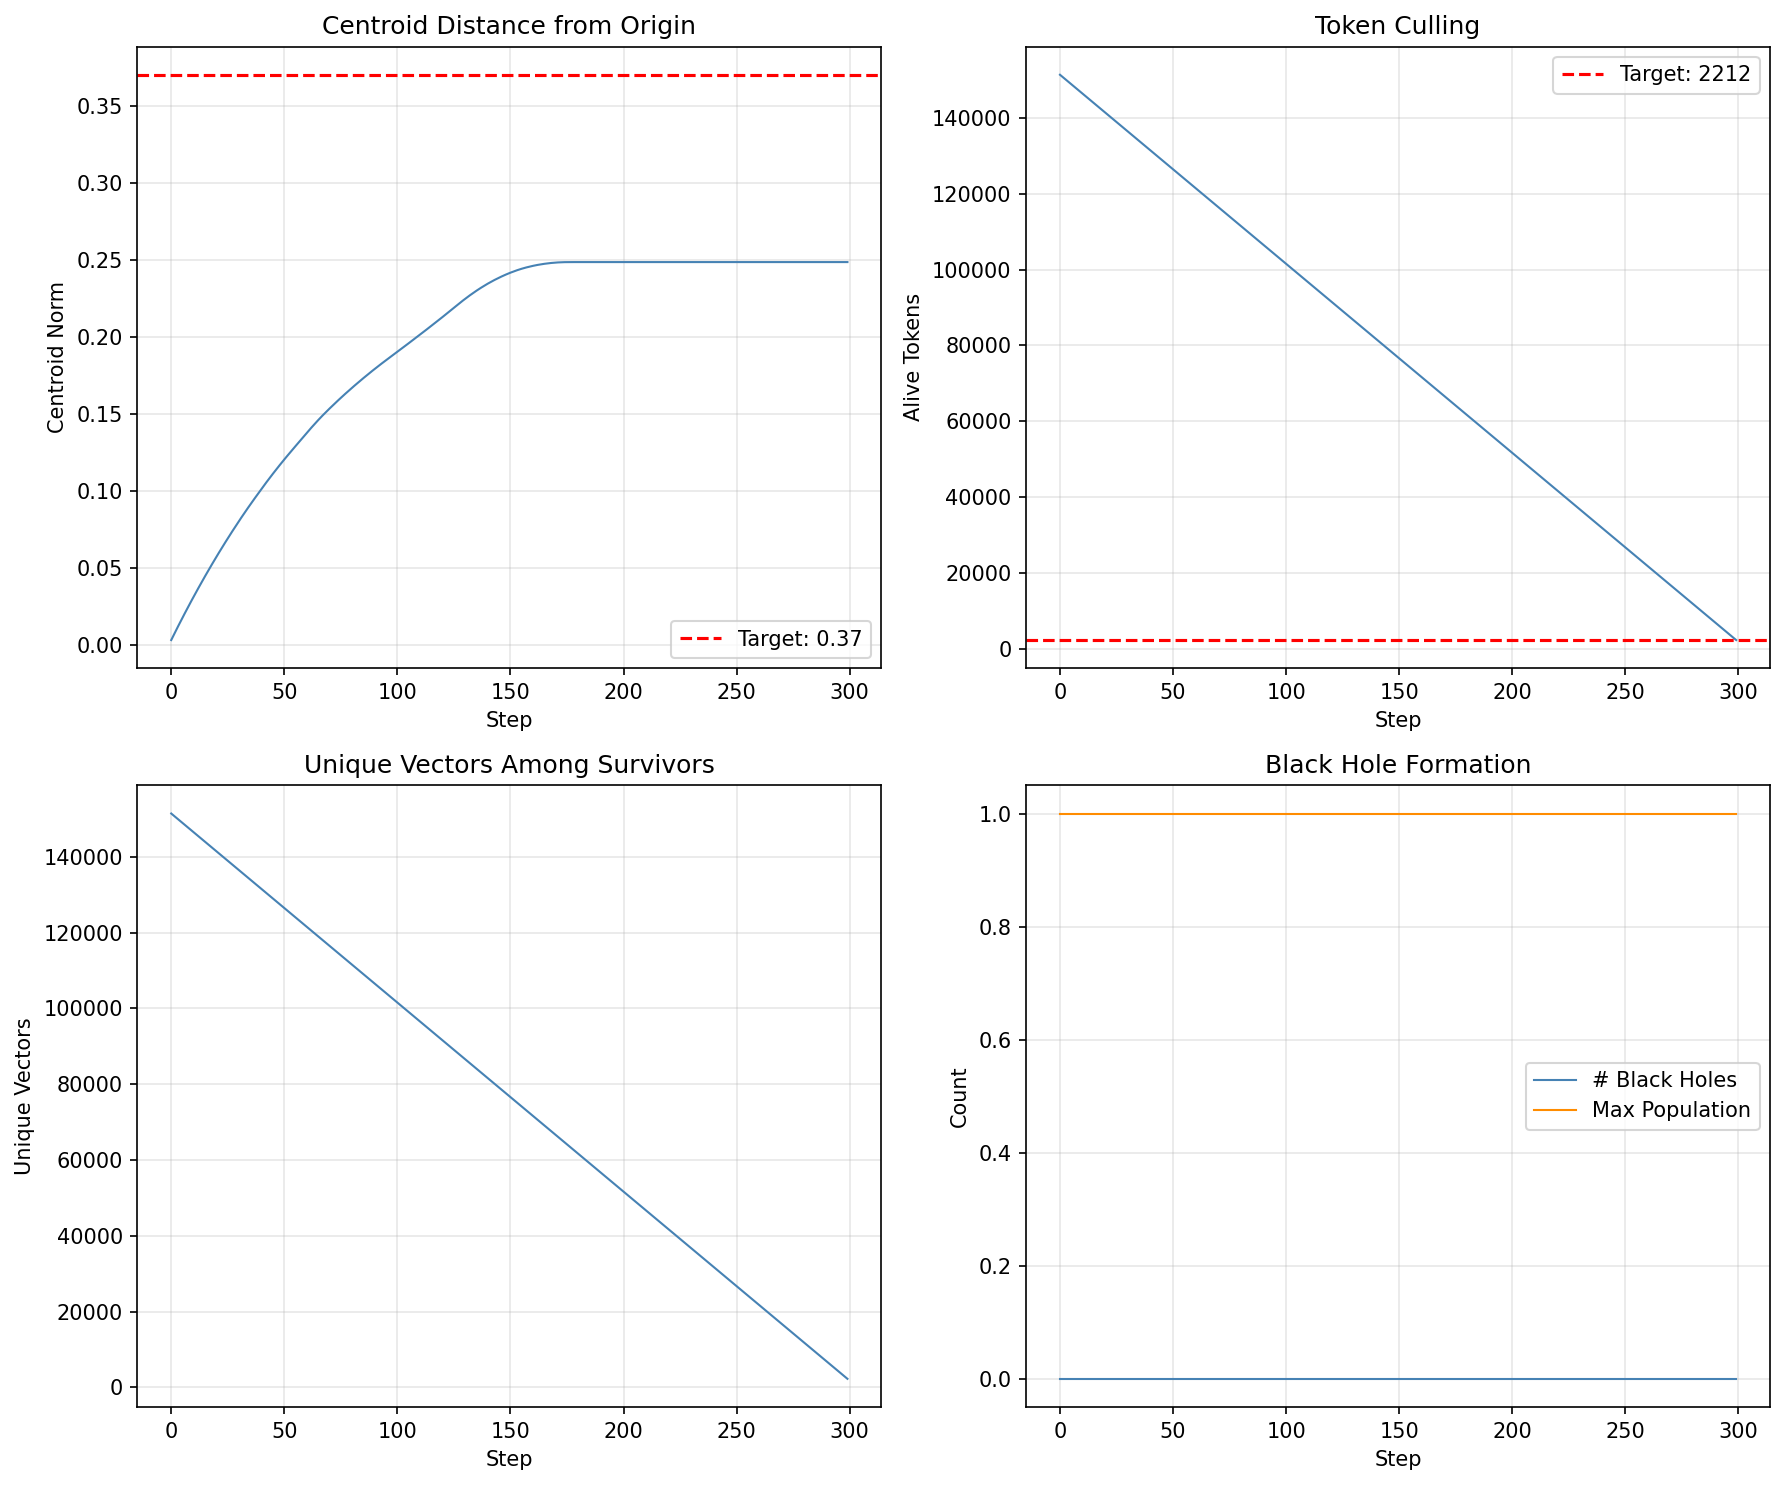

In [7]:
# Evolution plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)

steps = history['step']

# Centroid norm
ax = axes[0, 0]
ax.plot(steps, history['centroid_norm'], color='steelblue', linewidth=1)
ax.axhline(TARGET_RADIUS, color='red', linestyle='--', label=f'Target: {TARGET_RADIUS}')
ax.set_xlabel('Step')
ax.set_ylabel('Centroid Norm')
ax.set_title('Centroid Distance from Origin')
ax.legend()
ax.grid(True, alpha=0.3)

# Alive tokens
ax = axes[0, 1]
ax.plot(steps, history['n_alive'], color='steelblue', linewidth=1)
ax.axhline(N_SURVIVORS, color='red', linestyle='--', label=f'Target: {N_SURVIVORS}')
ax.set_xlabel('Step')
ax.set_ylabel('Alive Tokens')
ax.set_title('Token Culling')
ax.legend()
ax.grid(True, alpha=0.3)

# Unique vectors
ax = axes[1, 0]
ax.plot(steps, history['n_unique'], color='steelblue', linewidth=1)
ax.set_xlabel('Step')
ax.set_ylabel('Unique Vectors')
ax.set_title('Unique Vectors Among Survivors')
ax.grid(True, alpha=0.3)

# Black holes
ax = axes[1, 1]
ax.plot(steps, history['n_black_holes'], color='steelblue', linewidth=1, label='# Black Holes')
ax.plot(steps, history['max_population'], color='darkorange', linewidth=1, label='Max Population')
ax.set_xlabel('Step')
ax.set_ylabel('Count')
ax.set_title('Black Hole Formation')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../../notebooks/analysis/pachinko_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

## Comparison to Qwen Frozen Smoke

In [8]:
# Qwen frozen smoke statistics (from our analysis)
qwen_stats = {
    'survivors': 2212,
    'unique_vectors': 125,
    'black_holes': 13,
    'singletons': 112,
    'max_population': 814,
    'centroid_norm': 0.37
}

# Our simulation
sim_stats = {
    'survivors': n_survivors,
    'unique_vectors': n_unique,
    'black_holes': n_black_holes,
    'singletons': n_singletons,
    'max_population': max(counts.tolist()) if len(counts) > 0 else 0,
    'centroid_norm': history['centroid_norm'][-1]
}

print(f"{'Metric':<20} {'Qwen':>12} {'Simulation':>12} {'Match?':>10}")
print("-" * 56)
for key in qwen_stats:
    q = qwen_stats[key]
    s = sim_stats[key]
    if isinstance(q, float):
        match = '~' if abs(q - s) / q < 0.2 else '✗'
        print(f"{key:<20} {q:>12.4f} {s:>12.4f} {match:>10}")
    else:
        match = '~' if abs(q - s) / max(q, 1) < 0.5 else '✗'
        print(f"{key:<20} {q:>12,} {s:>12,} {match:>10}")

Metric                       Qwen   Simulation     Match?
--------------------------------------------------------
survivors                   2,212        2,236          ~
unique_vectors                125        2,236          ✗
black_holes                    13            0          ✗
singletons                    112        2,236          ✗
max_population                814            1          ✗
centroid_norm              0.3700       0.2484          ✗


## Summary

In [9]:
print("=" * 60)
print("PACHINKO SIMULATION SUMMARY")
print("=" * 60)
print()
print(f"HYPOTHESIS: Black holes form via lattice coarsening during drift")
print()
print(f"SIMULATION:")
print(f"  Initial tokens: {N_TOKENS:,}")
print(f"  Initial σ: {SIGMA_INIT}")
print(f"  Steps: {len(history['step'])}")
print(f"  Final survivors: {n_survivors:,}")
print(f"  Final centroid norm: {history['centroid_norm'][-1]:.4f}")
print()
print(f"RESULT:")
if n_black_holes > 0:
    print(f"  ✓ BLACK HOLES FORMED: {n_black_holes}")
    print(f"  ✓ Largest population: {max(counts.tolist())}")
    print(f"  ✓ Singletons: {n_singletons}")
else:
    print(f"  ✗ NO BLACK HOLES FORMED")
    print(f"  All {n_unique} vectors are singletons")
print()
print(f"VERDICT: {'HYPOTHESIS SUPPORTED' if n_black_holes > 0 else 'HYPOTHESIS NOT SUPPORTED'}")

PACHINKO SIMULATION SUMMARY

HYPOTHESIS: Black holes form via lattice coarsening during drift

SIMULATION:
  Initial tokens: 151,936
  Initial σ: 0.0001
  Steps: 300
  Final survivors: 2,236
  Final centroid norm: 0.2484

RESULT:
  ✗ NO BLACK HOLES FORMED
  All 2236 vectors are singletons

VERDICT: HYPOTHESIS NOT SUPPORTED
